In [308]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [309]:
#test
m = nn.Linear(2,3)
in_ = torch.randn(4,2)
out_ = m(in_)

A = torch.tensor([1,2,2])
B = torch.tensor([1]*3)
import numpy as np
np.math.atan(1000)
    

1.5697963271282298

#### How to simulate: $t_{j+1} = \int_{t_{j}}^{\infty} t .f^{*}(t) dt $ where $f^{*}(t) = \exp(at+b +c\exp(dt+e)-c\exp(at+b))$ a,b,c,d and e are randomly selected ?

In [310]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrale

In [317]:
#parameters
a,b,c,d,e = np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1)
tj = 0.05


In [318]:
#function
def f(t):
    return np.exp(a*t + b +c * np.exp(d*t + e) - c* np.exp(a*t+b))

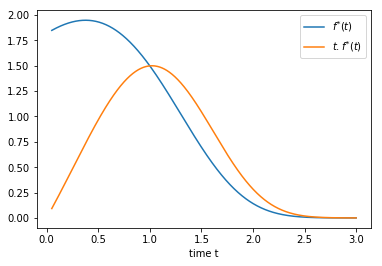

In [319]:
t = np.linspace(tj,3,1000)
ft = f(t)
tft = t*ft
plt.plot(t,ft,label="$f^{*}(t)$")
plt.plot(t,tft,label="$t.f^{*}(t)$")
plt.xlabel("time t")
plt.legend()

#### Conclusion: $ t.f^{*}(t)$ seems to be a continuous and derivable function

#### __1st method:__ Deterministic method: Riemann trapezoidal rule
#### $ \int_{t_{j}}^{\infty} t .f^{*}(t) dt \simeq \int_{t_{j}}^{A} g^{*}(t) dt \simeq \Delta T \sum_{i=0}^{N-1} \frac{g(x_{i}) + g(x_{i+1})}{2} $ where $\Delta T = \frac{A-t_{j}}{N}$

#### We have to estimate $A$. To do so, we say that the best candidate for $A$ verify $  \frac{\int_{t_{j}}^{A} g^{*}(t) - \int_{t_{j}}^{10 A} g^{*}(t)}{\int_{t_{j}}^{A} g^{*}(t)} < 0.05$

In [320]:
N = 10000
#return the value of the trapezoidal method for a given A
def trapezoidal(A):
    DeltaT = (A-tj)/N
    sum_ = 0
    discrete_time = np.array([DeltaT]*(N))
    discrete_time = np.concatenate((np.array([tj]),discrete_time))
    discrete_time = np.cumsum(discrete_time)

    discrete_f = discrete_time*f(discrete_time)
    sum_ = DeltaT * np.sum((discrete_f[1:] + discrete_f[:-1])/2)
    return sum_
A = 5*tj
sum_ = trapezoidal(A)
increment = 0
while(np.abs(trapezoidal(A) - trapezoidal(10*A))/trapezoidal(A) > 0.05 and increment < 1000):
    A = 10*A
    sum_ = trapezoidal(A)
    increment += 1
if(increment == 1000):
    print("The loop has been stopped because the sum doesn't converge")
print("Trapezoidal approximation of the integral:",sum_)

integral = integrale.quad(lambda t:t*f(t),tj,1000)
integral,error = integral
print("scipy result of the integral :", integral)


Trapezoidal approximation of the integral: 1.939942866765412
scipy result of the integral : 1.94224601783541


#### __2nd method:__ Integrale by substitution $t = \tan(u)$
#### $\int_{t_{j}}^{\infty} t .f^{*}(t) dt = \int_{ \tan^{-1}(t_{j})}^{\frac{\pi}{2}} \tan(u) .f^{*}(\tan(u)) \frac{1}{\cos^{2}(u)} du$
#### Thus, we don't have to simulate infinity A since the sampling is in a finite interval $[  \tan^{-1}(t_{j})  ,  \frac{\pi}{2} ]$

In [321]:
def h(u):
    return np.tan(u)*f(np.tan(u))*(1+np.tan(u)**2)



In [322]:
DeltaT = (np.pi/2-np.math.atan(tj))/N

discrete_time = np.array([DeltaT]*(N))
discrete_time = np.concatenate((np.array([np.arctan(tj)]),discrete_time))
discrete_time = np.cumsum(discrete_time)

discrete_h = h(discrete_time)
sum_ = DeltaT * np.sum((discrete_h[1:] + discrete_h[:-1])/2)
X = torch.tensor([1,2,3])
X = torch.cat((torch.tensor([0]),X))
X = X[1:] - X[:-1]
X

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([1, 1, 1])

#### Conclusion: Not stable! 

#### __3rd method:__ Using normal distribution
#### $\int_{t_{j}}^{\infty} t .f^{*}(t) dt = \int_{t_{j}}^{\infty} \sqrt{2\pi}.\exp(\frac{t^{2}}{2}). t .f^{*}(t) . \frac{1}{\sqrt{2\pi}}.\exp(-\frac{t^{2}}{2}) dt = \mathrm{E}(G(\mathrm{N})) $ where $N$ has a normal distribution with mean 0 and variance 1

In [323]:
def G(t,tj):
    return (t>tj) * np.sqrt(2*np.pi) * np.exp(t**2 / 2) * t * f(t)
sample = np.random.randn(N) 
sample = G(sample,tj)
print(np.mean(sample))

1.9807791619745703


## Conclusion: comparison of methods 1 and 3

#### Hidden Layer: $h_j = \max{(W^{y}y_{j} + W^{t}t_{j} + W^{h}h_{j-1} + b_{h},0)} $


#### Marker Generation: $P(y_{j+1}=k\mid h_{j}) = \frac{\exp(V_{k,:}^{y}h_{j} + b_{k}^{y})}{\sum_{k=1}^{K} \exp(V_{k,:}^{y}h_{j} + b_{k}^{y})} = \sigma(z)_{k}$ where $\sigma$ is softmax function and $z$ is the vector $ V^{y}h_{j} + b^{y}$ 


#### Conditional Density: $f^{*}(t) = \exp\{{v^{t}}^\top.h_{j} + w^t(t-t_{j}) + b^{t} + \frac{1}{w}\exp({v^{t}}^\top.h_{j} + b^{t}) -\frac{1}{w}\exp({v^{t}}^\top.h_{j} + w^t(t-t_{j}) + b^{t} )\} $

In [507]:
class Rmtpp(nn.Module):
    
    def __init__(self,marker_dim):
        #marker_dim equals to time_dim
        super(Rmtpp, self).__init__()
        #embedding yj for a more compact and efficient representation
        self.embedding = nn.Linear(1,1)
        #linear transformation
        self.lin_op = nn.Linear(3,1) 
        self.vt = nn.Linear(1,1)
        #weights
        self.w_t = torch.rand(1) 
        self.w = torch.rand(1) 
        self.V_y = torch.rand(marker_dim) #marker dim = number of markers 
        self.b_y = torch.rand(marker_dim) #bias
        
    
    #compute the function fstar
    def fstart(self,t,tj,hj):
        return torch.exp(self.vt(hj) + self.w_t*(t-tj) + 1/self.w * torch.exp(self.vt(hj)) -1/self.w * torch.exp(self.vt(hj) + self.w_t*(t-tj)))
    
    #compute integral of t*fstart(t) for tj to infinity using monteCarlo method
    def numerical_mean(self,tj,hj):
        N = 10000
        samp = torch.randn(N,1)
        sample = torch.sqrt(torch.tensor([2*F.math.pi]*N).unsqueeze(-1)) * torch.exp(1/2 * samp**2) * samp * self.fstart(samp,tj,hj)
        #I select only value greater than tj
        samp = samp.squeeze(1)
        sample = sample.squeeze(1)
        samp = samp>tj
        samp = samp.float()
        sample = torch.dot(samp,sample) 
        #then cumsum of sample 
        #print(torch.cumsum(sample,dim=0))
        return torch.cumsum(sample,dim=0)
        
        
        
    def forward(self, time, marker, hidden_state):
        print('-'*5,'***','-'*5)
        #I first compute next time
        tj = time
        print("tj :",tj)
        time = self.numerical_mean(time,hidden_state)
        print("time :",time)
        logfstar = -1 * torch.log(self.fstart(time,tj,hidden_state))
        print("logfstar :",logfstar)
        #print(logfstar)
        #print('-'*5,'1','-'*5)
        #Then next marker distribution
        soft_max = nn.LogSoftmax(dim=0) #softmax of rows
        logprob = -1 * soft_max(self.V_y*hidden_state + self.b_y) 
        #print(logprob)
        #print('-'*5,'2','-'*5)
        #Finally next hidden_state
        embedding = self.embedding(marker)
        input_ = torch.cat((embedding, time.unsqueeze(-1), hidden_state))
        hidden_state = F.relu(self.lin_op(input_))
        #print(hidden_state)
        #print('-'*5,'3','-'*5)
        return logprob, logfstar, hidden_state
    
    def init_hidden(self):
        return torch.zeros(1)
    
    def log_likelihood(self,log_time_series_list,log_marker_series_list):
        #time series and marker series are output of the RMTPP network
        #return log_likelihood of all sequences
        lll = 0
        for i in range(len(log_time_series_list)):
            lll += torch.sum(log_time_series_list) + torch.sum(log_marker_series_list)
        return lll       
                
        

## Training:

In [509]:
loss = nn.NLLLoss()
learning_rate = 0.0005
rnn = Rmtpp(10)


def train(time,marker):
    loss = 0
    hidden = rnn.init_hidden()
    lp = []
    lf = []
    for j in range(len(time)):
        tj = time[j]
        yj = marker[j]
        logprob, logfstar, hidden = rnn(tj, yj, hidden)
        #print(logfstar)
        lp.append(logprob)
        lf.append(logfstar)
    #loss = rnn.log_likelihood(-1*logfstar,-1*logprob)
    #return lf

t = torch.tensor([0.6,1.2,3.4,8.9])
m = torch.tensor([0,1,0,1])
t = t.unsqueeze(-1)
m = m.unsqueeze(-1)
#print(m)
t1 = torch.rand(4)
m1 = torch.rand(4)
print(t1)
t1 = t1.unsqueeze(-1)
m1 = m1.unsqueeze(-1)
train(t1,m1)


tensor([0.7861, 0.9646, 0.0208, 0.6110])
----- *** -----
tj : tensor([0.7861])
time : tensor(22237.5781, grad_fn=<CumsumBackward>)
logfstar : tensor([inf], grad_fn=<MulBackward>)
----- *** -----
tj : tensor([0.9646])
time : tensor(nan, grad_fn=<CumsumBackward>)
logfstar : tensor([nan], grad_fn=<MulBackward>)
----- *** -----
tj : tensor([0.0208])
time : tensor(nan, grad_fn=<CumsumBackward>)
logfstar : tensor([nan], grad_fn=<MulBackward>)
----- *** -----
tj : tensor([0.6110])
time : tensor(nan, grad_fn=<CumsumBackward>)
logfstar : tensor([nan], grad_fn=<MulBackward>)


# Tick.Hawkes

In [529]:
from tick.plot import plot_point_process
from tick.hawkes import SimuHawkes, HawkesKernelSumExp

#### 1 dimensional Hawkes process simulation using tick

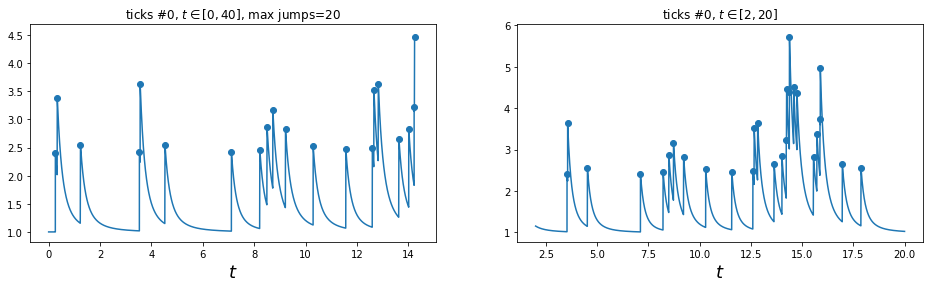

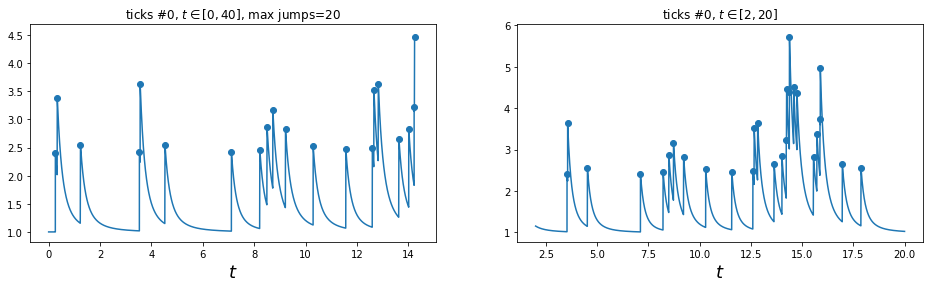

In [528]:
run_time = 40

hawkes = SimuHawkes(n_nodes=1, end_time=run_time, verbose=False, seed=1398)
kernel = HawkesKernelSumExp([.1, .2, .1], [1., 3., 7.])
hawkes.set_kernel(0, 0, kernel)
hawkes.set_baseline(0, 1.)

dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()
timestamps = hawkes.timestamps
intensity = hawkes.tracked_intensity
intensity_times = hawkes.intensity_tracked_times

_, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_point_process(hawkes, n_points=50000, t_min=0, max_jumps=20, ax=ax[0])
plot_point_process(hawkes, n_points=50000, t_min=2, t_max=20, ax=ax[1])

In [532]:
for i in intensity[0]:
    print(i)
    

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.4000000000000004
2.345034375429351
2.2820906671210963
2.222687243177857
2.1666047774770982
2.1136381911457622
2.063595706405622
2.0162979638818093
3.388998666669759
3.344943736640779
3.238098996776195
3.137167115466881
3.0417849180264454
2.951612723277094
2.8663327863377517
2.7856478457724743
2.7092797680708274
2.6369682829062744
2.5684698030609048
2.5035563233172926
2.442014393002828
2.383644157230468
2.328258462214219
2.2756820203494503
2.2257506310388733
2.1783104535160955
2.1332173281714653
2.0903361431206045
2.049540242975849
2.0107108769857507
1.9737366838989008
1.9385132110865642
1.9049424656247615
1.872932495191412
1.8423969967786327
1.8132549513550342
1.7854302827384934
1.7588515390570483
1.7334515952848215
1.7091673754417447
1.685939593140879
1.6637125092557112
1.6424337055624254
1.6220538732891892
1.6025266155763438
1.5838082629183798
1.5658577007210623
1.54863620816